<h1 style='background:#3E4491; border:2; border-radius:5px; font-size:200%; font-weight: bold;
color:white; padding:20px'><center>Estudo TG2 - Técnicas de Detecção de Fraudes usando Sistemas Inteligentes Híbridos</center></h1>

<center><img src = "Fraud_Detect.jpg" width = 900 height = 400/></center>

* Dataset (https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data):

    Dados fictícios que simulam 6.5 milhões de transações financeiras em sistema de carteira digital mobile, em que ~0,13% são fraudes. Trata-se de problema de aprendizado supervisionado (labeled data). Dados gerados pelo software Paysim, criado por Edgar Lopez e encontrado em https://github.com/EdgarLopezPhD/PaySim

* Tarefa:
Estudar técnicas diversas de aprendizado de máquina para detecção de fraudes financeiras, com foco Stacking Ensembles.

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">

<h1 style='background:#3E4491; border:0; border-radius: 10px; color:white;padding:20px'><center> Sumário </center></h1>

### [**1. Importando bibliotecas, carregando dados e Data Wrangling**](#title-one)

### [**2. EDA e Seleção de Features**](#title-two)

### [**3. Limpeza de dados**](#title-three)

### [**4. Pré-processamento de Dados**](#title-four)

### [**5. Modelagem**](#title-five)

### [**6. Pickle e Simulação de Deploy**](#title-six)

<a id="title-one"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>Importando bibliotecas, carregando dados e Data Wrangling</center></h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()
sns.color_palette('hls', 8)

# Definindo fonte
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30
        }

# Ignorando warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Carregando dados

In [2]:
fraud_df = pd.read_csv('Fraud.csv')
fraud_df_orig = fraud_df.copy()

fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
fraud_df.sample(10, random_state = 51)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3469883,258,CASH_OUT,67821.87,C866285988,0.00,0.00,C768926910,4619441.64,4687263.51,0,0
1280006,135,CASH_IN,85055.82,C1599550833,2115856.73,2200912.55,C202374280,2276459.94,2191404.12,0,0
2145172,184,DEBIT,10222.29,C566776604,51254.00,41031.71,C1958485216,1148028.05,1158250.34,0,0
4462790,323,PAYMENT,5706.39,C9932960,0.00,0.00,M356426859,0.00,0.00,0,0
2528257,205,CASH_IN,249181.72,C1284720763,2549153.18,2798334.90,C1706237454,1245176.53,995994.81,0,0
1246761,134,PAYMENT,4069.34,C2052023738,24643.00,20573.66,M1976782326,0.00,0.00,0,0
3593494,262,CASH_OUT,205270.03,C1188978390,0.00,0.00,C1521169523,533143.04,738413.07,0,0
3301733,252,CASH_IN,38373.00,C2114253306,4302341.30,4340714.31,C500941797,2471537.82,2601564.48,0,0
461078,19,PAYMENT,11099.74,C1494113517,30432.00,19332.26,M882538163,0.00,0.00,0,0
5941919,404,PAYMENT,15090.01,C358028744,500.00,0.00,M1597462434,0.00,0.00,0,0


#### - Colunas:

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Balanceando o Dataset (Undersampling)

In [4]:
frauds = fraud_df[fraud_df['isFraud'] == 1]
legits = fraud_df[fraud_df['isFraud'] == 0]

n_legits = len(legits)
n_frauds = len(frauds)

legits_percent = (n_legits / (n_frauds + n_legits)) * 100
frauds_percent = (n_frauds / (n_frauds + n_legits)) * 100

print("Número de transações legítimas: ", n_legits, '({:.4f}%).'.format(legits_percent))
print("Número de transações fraudulentas: ", n_frauds, '({:.4f}%).'.format(frauds_percent))

#Pegando 80% do total de transações fraudulentas para melhorar a performance do modelo de deploy
frauds = fraud_df[fraud_df['isFraud'] == 1].sample(frac = 0.82, random_state = 42)
n_frauds = len(frauds) #resetando valor de n_frauds para a mudança anterior

legits = legits.sample(n = n_frauds, random_state = 42)
df_reduced = pd.concat([frauds, legits], axis = 0)

fraud_value_counts = df_reduced.isFraud.value_counts(normalize = True)
print(f'\nFazendo o Undersampling, temos agora {fraud_value_counts[0]*100}% de transações legítimas e {fraud_value_counts[1]*100}% de transações fraudulentas.')

Número de transações legítimas:  6354407 (99.8709%).
Número de transações fraudulentas:  8213 (0.1291%).

Fazendo o Undersampling, temos agora 50.0% de transações legítimas e 50.0% de transações fraudulentas.


<a id="title-two"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>EDA e Seleção de Features</center></h1>

In [5]:
df_reduced.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6266285,615,TRANSFER,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0
6358608,714,TRANSFER,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0
4472587,324,TRANSFER,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0
6293769,668,CASH_OUT,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0
6055691,499,TRANSFER,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0


In [6]:
# Lista das variáveis numéricas de ponto flutuante
numericals = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

df_reduced[numericals].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,1.347000e+04,1.347000e+04,1.347000e+04,1.347000e+04,1.347000e+04
mean,8.295822e+05,1.257918e+06,5.356563e+05,8.459625e+05,1.272983e+06
std,1.859142e+06,3.280919e+06,2.537092e+06,3.694038e+06,4.009343e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.823532e+04,1.028950e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.754158e+05,1.221545e+05,0.000000e+00,0.000000e+00,1.353454e+05
75%,5.396587e+05,8.037945e+05,0.000000e+00,5.323540e+05,1.101243e+06
max,1.199796e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08


In [7]:
# Importando biblioteca p/ calcular o VIF (Variance Inflation Factor)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculando VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(df_reduced.drop(['step', 'type', 'nameOrig', 'nameDest'], axis = 1))

,variables,VIF
0,amount,32.857062
1,oldbalanceOrg,92.437668
2,newbalanceOrig,49.364461
3,oldbalanceDest,15.863069
4,newbalanceDest,17.670754
5,isFraud,1.390407
6,isFlaggedFraud,1.237226


In [8]:
# # Podemos ver que Saldo Anterior na Origem (*oldbalanceOrg*) e Saldo Atual na Origem (*newbalanceOrig*) tem altíssimos VIF's, assim mostrando que estão altamente correlacionados.
# # O mesmo ocorre para Saldo Anterior no Destino (*oldbalanceDest*) e Saldo Atual no Destino (*newbalanceDest*). Vamos juntar esse par de variáveis colineares e *dropar* elas individualmente.

# df_reduced['actualAmountOrig'] = df_reduced.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'], axis = 1)
# df_reduced['actualAmountDest'] = df_reduced.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'], axis = 1)

# # Dropando colunas individuais
# df_reduced = df_reduced.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis = 1)

# # Recalculando VIF
# calc_vif(df_reduced.drop(['step', 'type', 'nameOrig', 'nameDest'], axis = 1))

<Figure size 1440x1296 with 0 Axes>

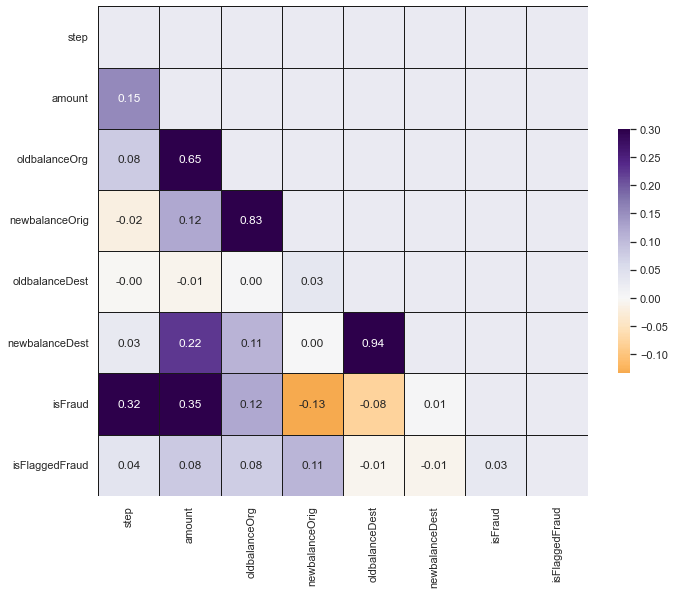

In [9]:
plt.figure(figsize=(20,18))

corr = df_reduced.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = 'PuOr', vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5},
            linecolor = 'k', fmt = '.2f', annot = True)
plt.show()

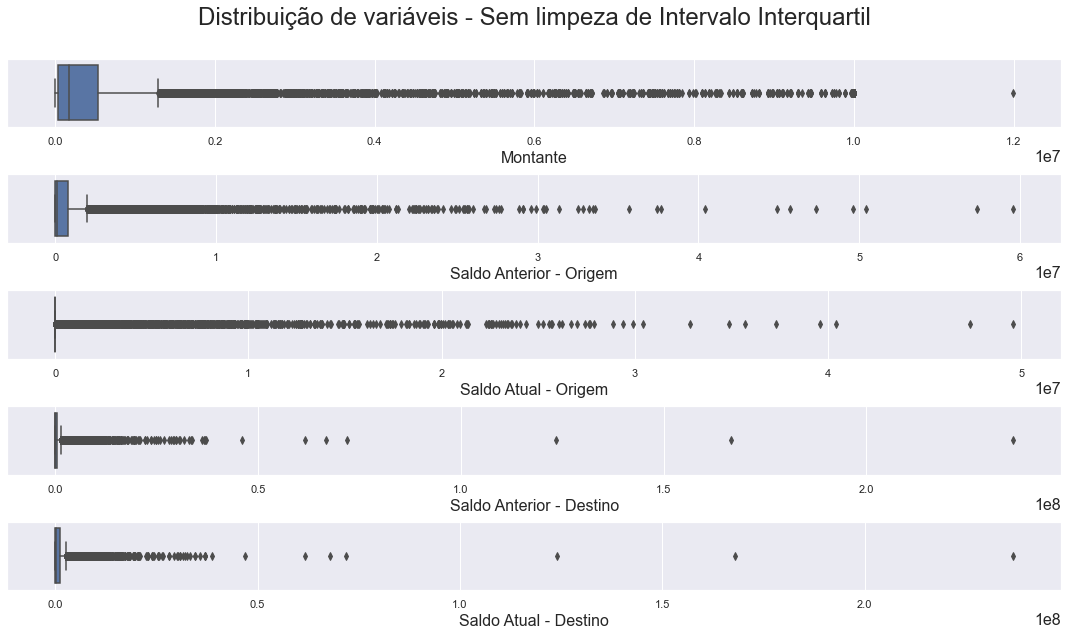

In [10]:
nome_colunas = {'amount': 'Montante',
                'oldbalanceOrg': 'Saldo Anterior - Origem',
                'newbalanceOrig': 'Saldo Atual - Origem',
                'oldbalanceDest': 'Saldo Anterior - Destino',
                'newbalanceDest': 'Saldo Atual - Destino',
                'step': 'Passo - Tempo',
                'isFraud': 'Fraude',
                'isFlaggedFraud': 'Flag de Fraude',
                }

fig = plt.figure(figsize = (15,9))

num_cols = list(df_reduced.select_dtypes(exclude = ['object','int64']).columns)

for i, col in enumerate(num_cols):
    ax = fig.add_subplot(len(nome_colunas)-3, 1, i+1)
    sns.boxplot(x = df_reduced[col], ax = ax)
    plt.xlabel(nome_colunas[col], fontdict={'fontsize': 16})
    fig.tight_layout()
    ax.xaxis.offsetText.set_fontsize(16)

fig.suptitle('Distribuição de variáveis - Sem limpeza de Intervalo Interquartil\n', size = 24)
plt.subplots_adjust(top = 0.90)
plt.show()

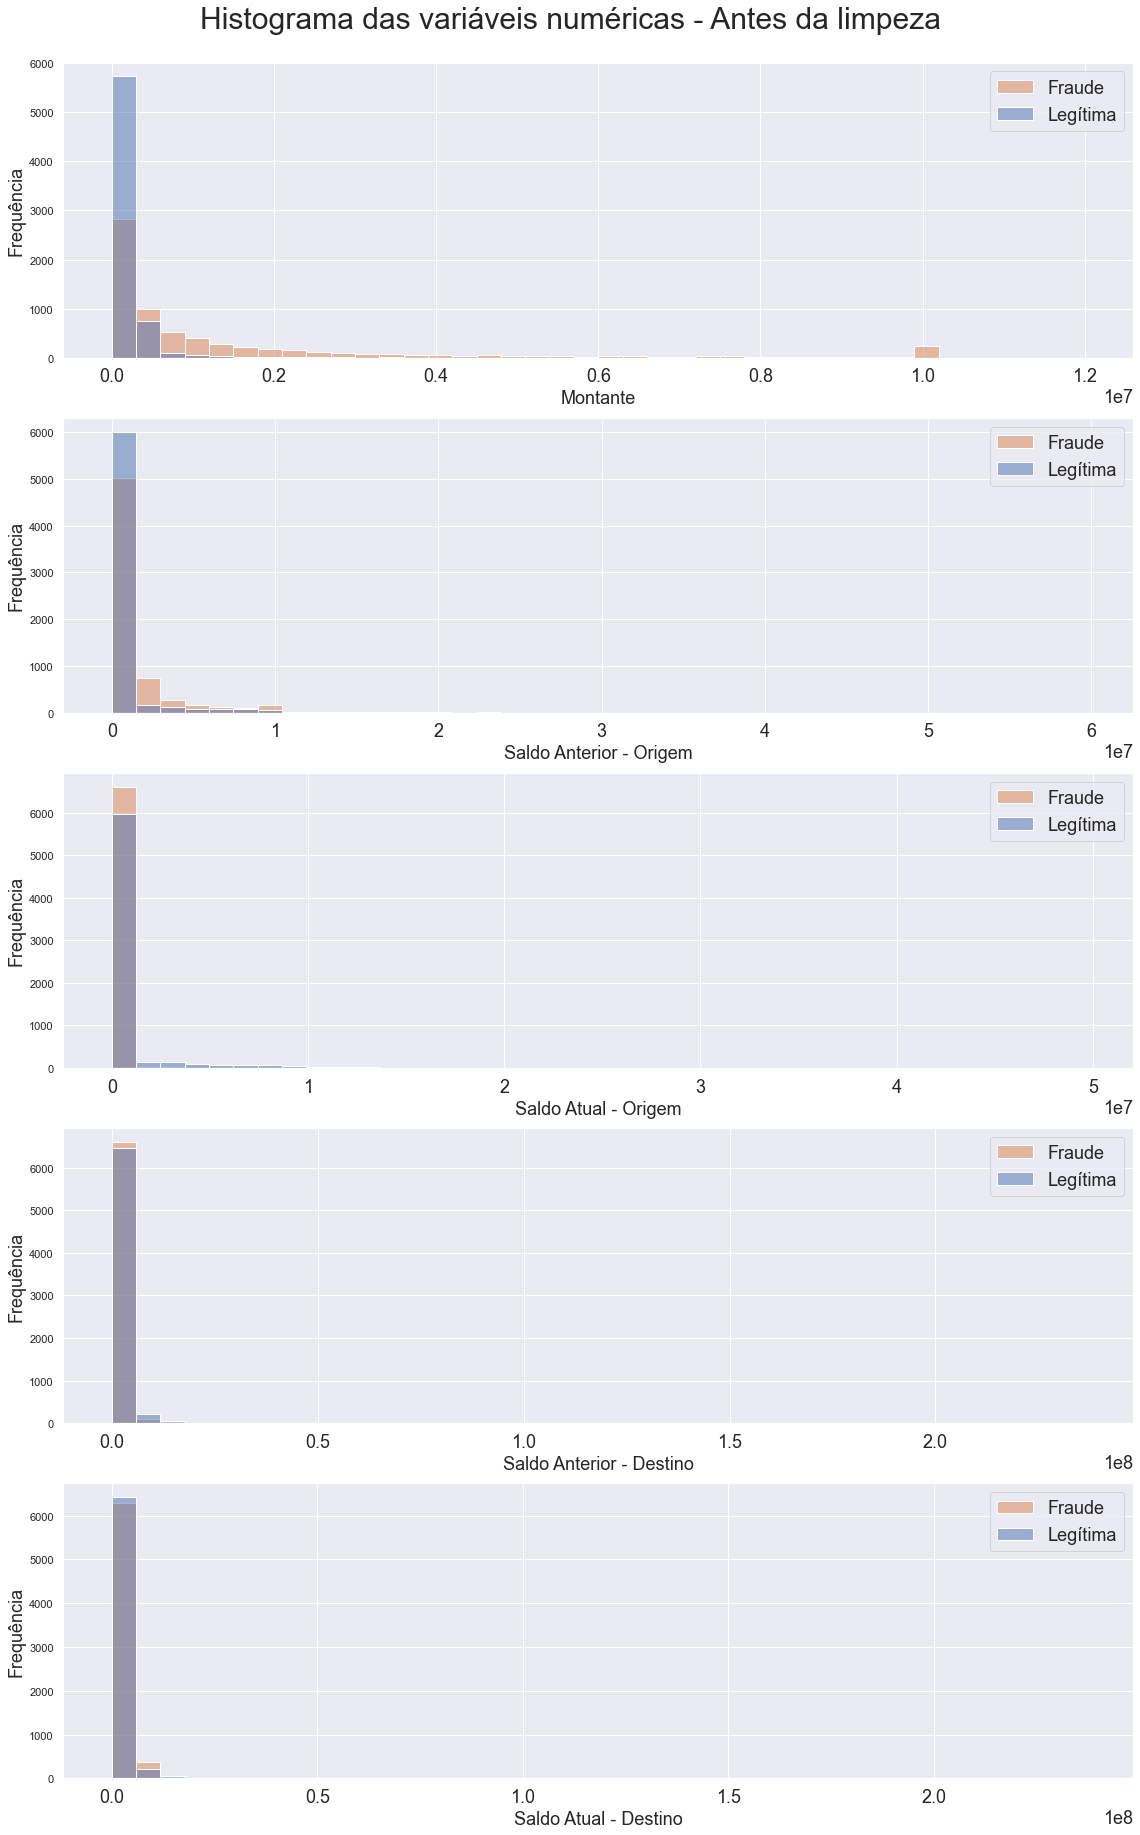

In [11]:
fig, axs = plt.subplots(len(nome_colunas)-3, 1, figsize = (16,26))

for i, col in enumerate(numericals):
    sns.histplot(data = df_reduced, x = col, hue = 'isFraud', ax = axs[i], bins = 40)
    axs[i].set_xlabel(nome_colunas[col], fontdict = {'fontsize': 18})
    axs[i].set_ylabel('Frequência', fontdict = {'fontsize': 18})
    axs[i].legend(['Fraude', 'Legítima'], fontsize = 18)
    axs[i].tick_params(axis = 'x', labelsize = 18)
    axs[i].xaxis.offsetText.set_fontsize(18)

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Histograma das variáveis numéricas - Antes da limpeza', fontsize = 30);

In [12]:
# from bokeh.plotting import figure, output_notebook, show, output_file
# from bokeh.models import ColumnDataSource

# p = figure(plot_width = 300, plot_height = 300, tools = "pan,reset,save")
# source = ColumnDataSource(data = dict(x = sample1.amount, y = sample1.index))

# p.circle(x='x', y = 'y', source=source, color = 'navy', alpha = 0.5)

# output_notebook()
# show(p)

As features selecionadas são: Montante, Saldo Anterior - Origem, Saldo Atual - Origem, Saldo Anterior - Destino, Saldo Atual - Destino e **Fraude (variável alvo)**. As variáveis *Step*, nome das contas e *flag* de fraude foram *dropadas* pois não representavam nenhum poder preditivo e poderiam atrapalhar o treinamento.

<a id="title-three"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>Limpeza de Dados</center></h1>

# Data Cleaning

In [13]:
# from dataprep.eda import plot

# plot(df_reduced)

In [14]:
df_clean = df_reduced.copy()

print('Número de linhas pré limpeza: ', df_reduced.shape[0])

# Limpando as colunas numéricas (fazendo somente limite superior pois muitos valores nulos - contas sem dinheiro)

for i in ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest']: #numericals dá erro porque newbalanceOrig tem praticamente todos seus valores nulos assim dropnando todo o dataset
    
    q1, q3 = np.percentile(df_clean[i], [25, 75])
    
    iqr = q3 - q1
    lim_sup = q3 + 1.75 * iqr

    indice = df_clean[df_clean[i] >= lim_sup].index

    df_clean.drop(indice, inplace = True)

print('Número de linhas pós limpeza: ', df_clean.shape[0])

Número de linhas pré limpeza:  13470
Número de linhas pós limpeza:  8402


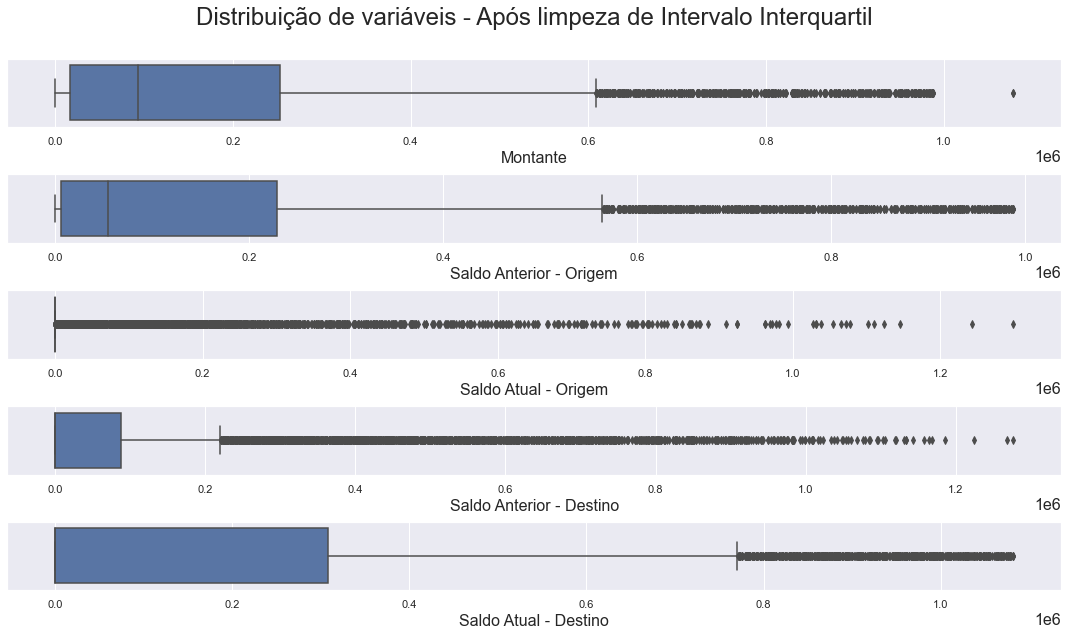

In [15]:
fig = plt.figure(figsize= (15,9))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(len(nome_colunas)-3, 1, i+1)      
    sns.boxplot(x = df_clean[col], ax = ax)
    plt.xlabel(nome_colunas[col], fontdict = {'fontsize': 16})
    fig.tight_layout()
    ax.xaxis.offsetText.set_fontsize(16)

fig.suptitle('Distribuição de variáveis - Após limpeza de Intervalo Interquartil\n', size = 24)
plt.subplots_adjust(top = 0.90)
plt.show()

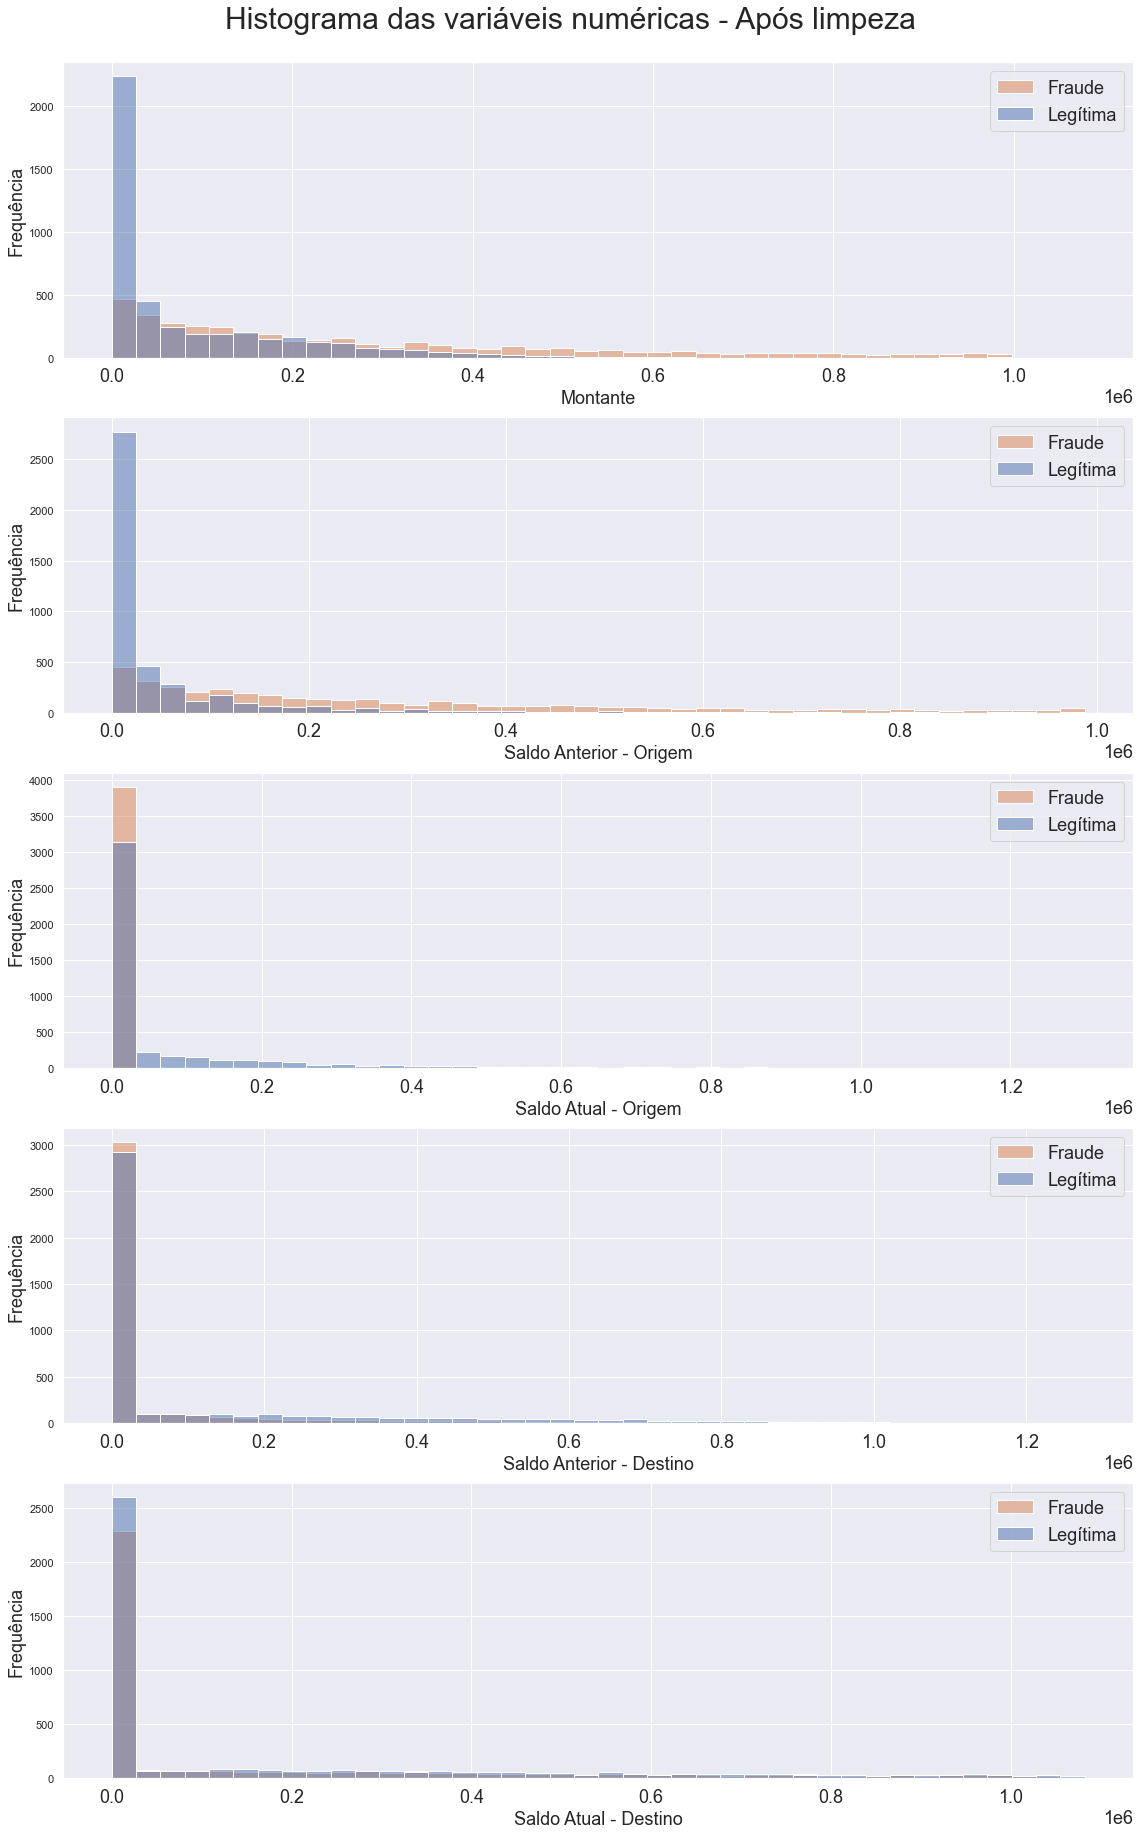

In [16]:
fig, axs = plt.subplots(len(nome_colunas)-3, 1, figsize = (16,26))

for i, col in enumerate(numericals):
    sns.histplot(data = df_clean, x = col, hue = 'isFraud', ax = axs[i], bins = 40)
    axs[i].set_xlabel(nome_colunas[col], fontdict = {'fontsize': 18})
    axs[i].set_ylabel('Frequência', fontdict={'fontsize': 18})
    axs[i].legend(['Fraude', 'Legítima'], fontsize = 18)
    axs[i].tick_params(axis = 'x', labelsize = 18)
    axs[i].xaxis.offsetText.set_fontsize(18)

fig.tight_layout()
fig.subplots_adjust(top = 0.95)
fig.suptitle('Histograma das variáveis numéricas - Após limpeza', fontsize = 30);

In [17]:
df_clean[numericals].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,8.402000e+03,8402.000000,8.402000e+03,8.402000e+03,8.402000e+03
mean,1.770054e+05,163045.416249,3.917109e+04,1.022137e+05,1.858743e+05
std,2.170001e+05,227103.018220,1.213261e+05,2.109942e+05,2.887109e+05
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.709889e+04,5618.500000,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.337904e+04,54892.980000,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.536487e+05,228790.927500,0.000000e+00,8.822789e+04,3.083139e+05
max,1.078415e+06,987591.590000,1.299078e+06,1.276795e+06,1.082147e+06


<a id="title-four"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>Pré-processamento de Dados</center></h1>

In [18]:
#Imports de Modelagem (Pré-processamento: Normalização, Splits; Validação; e Modelos)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier, IsolationForest
from xgboost import XGBClassifier

In [19]:
#Normalização das variáveis numéricas

df_clean[numericals] = StandardScaler().fit_transform(df_clean[numericals])

# Codificação da coluna 'Type' (categórica)

codec = pd.DataFrame(df_reduced['type'].factorize()[1], columns = ['type'])
print('* Codificação da variável categórica "type":  \n\n', codec)

df_clean['type'] = df_clean['type'].factorize()[0]

* Codificação da variável categórica "type":  

        type
0  TRANSFER
1  CASH_OUT
2   PAYMENT
3   CASH_IN
4     DEBIT


In [20]:
#Definição de Features e Target

features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

X = df_clean[features]
y = df_clean['isFraud']

#Splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

<a id="title-five"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>Modelagem</center></h1>

### Testando Modelos com cross_val_score

In [21]:
# Criando comparação de acurácia entre os 6 modelos escolhidos

comparacao_modelos = pd.DataFrame(columns = ['Modelo', 'Score'])

modelos = [LogisticRegression('l2', solver='lbfgs', random_state=42),
           KNeighborsClassifier(n_neighbors = 41, p = 4),
           ExtraTreesClassifier(random_state = 42),
           IsolationForest(n_jobs = -1, random_state = 42),
           XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
           StackingClassifier(estimators = [('xgbc', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)),
                                           ('log_reg', LogisticRegression(n_jobs = -1, random_state=42))
                                           ],
                              final_estimator=LogisticRegression('l2', solver='lbfgs', random_state=42)
                              )
           ]

for model in modelos:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
    comparacao_modelos.loc[len(comparacao_modelos)] = [model_name, scores.mean().round(4)]

comparacao_modelos = comparacao_modelos.sort_values(by='Score', ascending=False)

print('* Comparação Cross-Validation Score entre modelos: ')
comparacao_modelos

* Comparação Cross-Validation Score entre modelos: 


,Modelo,Score
5,StackingClassifier,0.9922
4,XGBClassifier,0.9917
2,ExtraTreesClassifier,0.9820
0,LogisticRegression,0.9738
1,KNeighborsClassifier,0.9449
3,IsolationForest,0.3785


### * Modelo Baseline: Dummy Classifier

In [22]:
# Definindo objeto do modelo e seus parâmetros

dummymodel = DummyClassifier(strategy = 'prior')
dummymodel.fit(X_train, y_train) # Treinando modelo

y_pred_dummy = dummymodel.predict(X_test) # Criando lista das predições

Acurácia:  0.5351


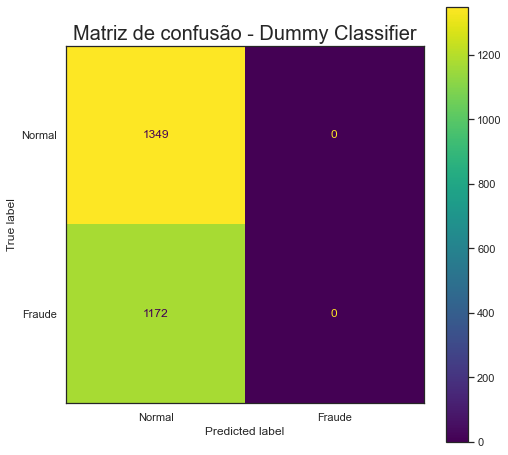

In [23]:
# Métricas e Matriz de Confusão

print('Acurácia: ', accuracy_score(y_test, y_pred_dummy).round(4))

sns.set_theme(style = 'white')
cmd1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dummy), display_labels = ['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize = (8,8))
plt.grid(False)
cmd1.plot(ax = ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Dummy Classifier', fontsize = 20)
plt.show()

### * 1º Modelo: Extra Trees Classifier

In [24]:
# Definindo objeto do modelo e seus parâmetros constantes

xtc = ExtraTreesClassifier(warm_start = True, n_jobs = -1, random_state = 42)

In [25]:
# Definindo espaço de busca dos hiperparâmetros e executando otimização Bayesiana destes
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

xtc_param_dict = {'n_estimators': Integer(2, 800),
                  'criterion': Categorical(['gini', 'entropy']),
                  'max_depth': Integer(1, 15)
                  }

bayessearch_xtc = BayesSearchCV(xtc,
                                search_spaces = xtc_param_dict,
                                scoring = 'f1',
                                cv = 3,
                                refit = 'recall',
                                # verbose = 1,
                                n_jobs = -1,
                                random_state = 42
                                ).fit(X_train, y_train)

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



Melhores Parâmetros:  OrderedDict([('criterion', 'entropy'), ('max_depth', 15), ('n_estimators', 800)]) 
Melhor Score:  0.9774505776628503 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1349
           1       0.97      0.99      0.98      1172

    accuracy                           0.98      2521
   macro avg       0.98      0.98      0.98      2521
weighted avg       0.98      0.98      0.98      2521



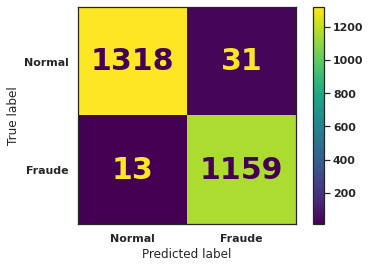

In [26]:
# Imprimindo resultados: Melhores parâmetros, melhor score, report de métricas e matriz confusão

print('\nMelhores Parâmetros: ', bayessearch_xtc.best_params_,
      '\nMelhor Score: ', bayessearch_xtc.best_score_,
      '\n', classification_report(y_test, bayessearch_xtc.predict(X_test))
      )

xtc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_xtc.predict(X_test)),
                                display_labels = ['Normal', 'Fraude']
                                ).plot()

#### Feature Importance (a título de curiosidade)

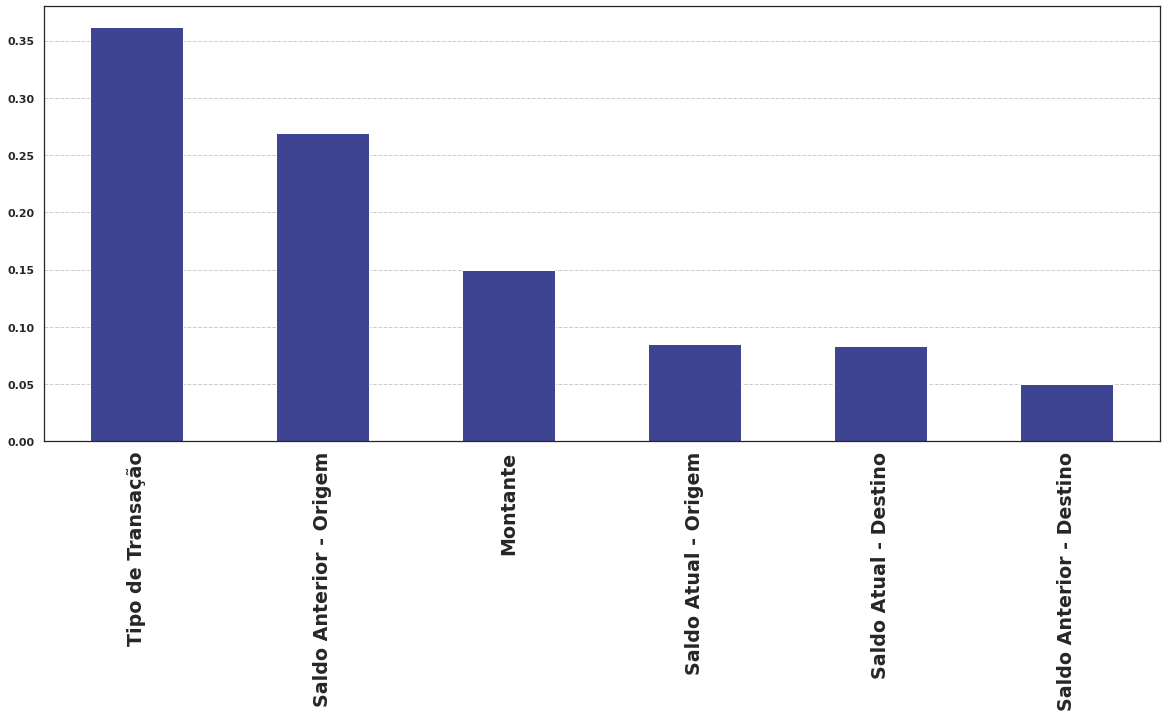

In [27]:
# Lista para renomear as features na visualização
feats_ptbr = ['Tipo de Transação',
              'Montante',
              'Saldo Anterior - Origem',
              'Saldo Atual - Origem',
              'Saldo Anterior - Destino',
              'Saldo Atual - Destino'
              ]

# Chamando método de importâncias das features para o modelo ExtraTreesClassifier
feat_importance = pd.Series(xtc.fit(X_train, y_train).feature_importances_,
                            index=feats_ptbr
                            ).sort_values(ascending=False)

plt.figure(figsize = (20,8))
feat_importance.plot(kind = 'bar', color = '#3E4491')
plt.grid(which = 'major', axis = 'y', linestyle = '--')
plt.xticks(fontsize = 19);

### * 2º Modelo: XGBoost Classifier

In [28]:
# Definindo objeto do modelo e seus parâmetros constantes

xgbc = XGBClassifier(eval_metric = 'logloss',
                     objective = 'binary:logistic',
                     use_label_encoder = False,
                     n_jobs = -1
                     )

In [29]:
# Definindo espaço de busca dos hiperparâmetros e executando otimização Bayesiana destes

xgbc_param_dict = {'learning_rate': Real(0.01, 0.99),
                   'max_depth': Integer(3,8),
                   'max_leaves': Integer(10, 100),
                  'n_estimators': Integer(1, 1000)
                   }

bayessearch_xgbc = BayesSearchCV(xgbc,
                                 search_spaces = xgbc_param_dict,
                                 scoring = 'recall',
                                 cv = 3,
                                 refit = 'recall',
                                #  verbose = 1,
                                 n_jobs = -1,
                                 random_state = 42
                                 ).fit(X_train, y_train)


Melhores Parâmetros:  OrderedDict([('learning_rate', 0.01), ('max_depth', 6), ('max_leaves', 10), ('n_estimators', 197)]) 
 Melhor Score:  0.9970756221875582 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1349
           1       0.98      1.00      0.99      1172

    accuracy                           0.99      2521
   macro avg       0.99      0.99      0.99      2521
weighted avg       0.99      0.99      0.99      2521



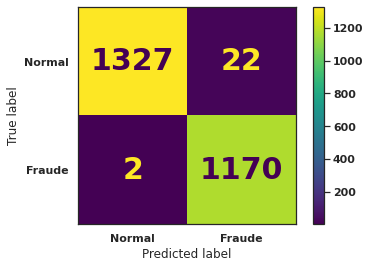

In [30]:
# Imprimindo resultados: Melhores parâmetros, melhor score, report de métricas e matriz confusão

print('\nMelhores Parâmetros: ', bayessearch_xgbc.best_params_,
      '\n Melhor Score: ', bayessearch_xgbc.best_score_, '\n',
      classification_report(y_test, bayessearch_xgbc.predict(X_test))
      )
xgbc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_xgbc.predict(X_test)), display_labels = ['Normal', 'Fraude']).plot()

### * 3º Modelo: Isolation Forest Classifier

In [31]:
# Definindo objeto do modelo e seus parâmetros constantes

ifc = IsolationForest(n_estimators = 7,
                      max_samples = 0.5,
                      contamination = 0.5,
                      max_features = 1,
                      n_jobs = -1,
                    #   warm_start = True,
                      random_state = 42
                      ).fit(X_train.values)

In [32]:
# List Comprehension para mapear saída do modelo como a saída do predict dos outros modelos
# Mapeando -1 para 1 e 1 para 0

ifc_y_pred = [1 if i == -1 else 0 for i in ifc.predict(X_test.values)]

              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1349
           1       0.50      0.56      0.53      1172

    accuracy                           0.54      2521
   macro avg       0.54      0.54      0.54      2521
weighted avg       0.54      0.54      0.54      2521



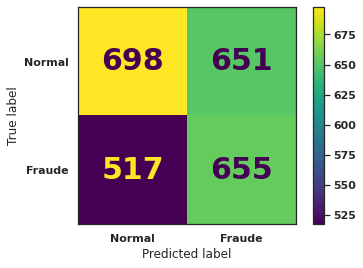

In [33]:
# Imprimindo resultados: report de métricas e matriz confusão

print(classification_report(y_test, ifc_y_pred))
ifc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, ifc_y_pred), display_labels = ['Normal', 'Fraude']).plot()

### Tentativa de fazer Isolation Forest funcionar como preditor padrão e otimizar via Bayes

In [34]:
# from sklearn.model_selection import GridSearchCV

# ifc_param_dict = {'n_estimators': [2, 4, 7, 9, 20, 50, 100, 1000],
#                   'bootstrap': [True, False],
#                   'max_features': [1, 2, 3, 6]
#                   }

# gridsearch_ifc = GridSearchCV(ifc,
#                               param_grid = ifc_param_dict,
#                               scoring = 'recall',
#                               cv = 3,
#                               refit = 'recall',
#                               verbose = 1,
#                               n_jobs = -1
#                               ).fit(X_train.values)

# ifc_y_pred_grid = [1 if i == -1 else 0 for i in gridsearch_ifc.predict(X_test.values)]

In [35]:
# df_ifc = fraud_df.copy()

# df_ifc = df_ifc.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# df_ifc[numericals] = StandardScaler().fit_transform(df_ifc[numericals])
# df_ifc['type'] = df_ifc['type'].factorize()[0]

# X_train_ifc, X_test_ifc, y_train_ifc, y_test_ifc = train_test_split(df_ifc.drop('isFraud', axis=1), df_ifc['isFraud'], test_size=0.3, stratify=df_ifc['isFraud'], random_state=42)

In [36]:
# # Isolation Forest

# ifc_unbalance = IsolationForest(n_estimators = 100,
#                                 max_samples = 0.4,
#                                 contamination = df_ifc['isFraud'].value_counts(normalize=True)[1]*10,
#                                 max_features = 1,
#                                 n_jobs = -1,
#                                 random_state = 42
#                                 ).fit(X_train_ifc.values)

In [37]:
# numpy_map = np.vectorize(lambda x: 1 if x == -1 else 0)

# ifc_y_pred_unbalance = numpy_map(ifc.predict(X_test_ifc.values))

In [38]:
# print(df_ifc['isFraud'].value_counts(normalize=True)[1])

# print(pd.DataFrame(ifc.predict(X_test_ifc.values)).value_counts(normalize=True))

In [39]:
# print(classification_report(y_test_ifc, ifc_y_pred_unbalance))
# ifc_cm = ConfusionMatrixDisplay(confusion_matrix(y_test_ifc, ifc_y_pred_unbalance), display_labels=['Normal', 'Fraude']).plot()

Resultados muito ruins - mesmo utilizando de todos os 6.5M de dados para treino/teste, fazendo gambiarras para usar otimização bayesiana e como preditor comum, e ainda assim - , modelo pior que o mero chute! Não vale e pena seguir com esse modelo para o Stacking Ensemble. Utilizaremos a Regressão Logística, já que se trata de modelo com relação custo (computacional)-benefício (resultados, métricas etc) das mais altas na classificação, fora ainda a interpretabilidade e simplicidade de explicação.

### * 4º Modelo: Regressão Logística

In [40]:
# Definindo objeto do modelo e seus parâmetros constantes

log_reg = LogisticRegression(n_jobs = -1, random_state = 42)

In [41]:
# Definindo espaço de busca dos hiperparâmetros e executando otimização Bayesiana destes

logreg_param_dict = {'penalty': Categorical(['l2', 'none']),
                     'C': Real(0.01, 1.0),
                     'class_weight': Categorical(['balanced', None]),
                     'solver': Categorical(['newton-cg', 'lbfgs', 'sag', 'saga'])
                     }

bayessearch_logreg = BayesSearchCV(log_reg,
                                   search_spaces = logreg_param_dict,
                                   scoring = 'recall',
                                   cv = 3,
                                   refit = 'recall',
                                #    verbose = 1,
                                   n_jobs = -1,
                                   random_state = 42
                                   ).fit(X_train, y_train)

c:\Users\Felipe\anaconda3\envs\Fraud_Deteciton_TCC_2\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(



Melhores Parâmetros:  OrderedDict([('C', 0.10666447071438619), ('class_weight', 'balanced'), ('penalty', 'none'), ('solver', 'lbfgs')]) 
 Melhor Score:  0.9934190466103056 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1349
           1       0.97      0.99      0.98      1172

    accuracy                           0.98      2521
   macro avg       0.98      0.98      0.98      2521
weighted avg       0.98      0.98      0.98      2521



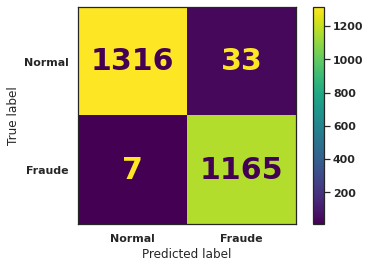

In [42]:
# Imprimindo resultados: Melhores parâmetros, melhor score, report de métricas e matriz confusão

print('\nMelhores Parâmetros: ', bayessearch_logreg.best_params_,
      '\n Melhor Score: ', bayessearch_logreg.best_score_, '\n',
      classification_report(y_test, bayessearch_logreg.predict(X_test)))

logreg_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, bayessearch_logreg.predict(X_test)), display_labels = ['Normal', 'Fraude']).plot()

### * 5º Modelo: Stacking Classifier

In [43]:
# Definindo objeto do modelo: modelos base, modelo final e seus respectivos parâmetros constantes

stack = StackingClassifier(estimators = [('xgbc', bayessearch_xgbc.best_estimator_),
                                         ('log_reg', bayessearch_logreg.best_estimator_)
                                         ],
                           final_estimator = LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', random_state = 41, n_jobs = -1, max_iter = 500),
                           n_jobs = -1,
                           passthrough = True
                           ).fit(X_train, y_train)

Acurácia:  0.9913
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1349
           1       0.98      1.00      0.99      1172

    accuracy                           0.99      2521
   macro avg       0.99      0.99      0.99      2521
weighted avg       0.99      0.99      0.99      2521



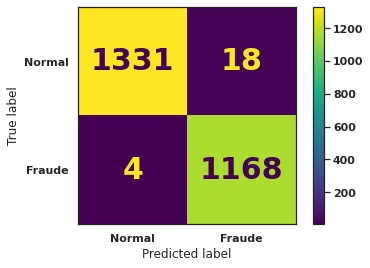

In [44]:
# Imprimindo resultados: Acurácia, report de métricas e matriz confusão

print('Acurácia: ', accuracy_score(y_test, stack.predict(X_test)).round(4))
print(classification_report(y_test, stack.predict(X_test)))
stack_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, stack.predict(X_test)), display_labels = ['Normal', 'Fraude']).plot()

## Comparativo Final dos Modelos

### Tabela de Métricas

In [45]:
comparativo_final_metricas = pd.DataFrame(columns = ['Acurácia', 'Recall', 'FN', 'F1-Score', 'AUROC'])

comparativo_dict = {'Dummy': dummymodel.predict(X_test),
                    'Extra Trees': bayessearch_xtc.predict(X_test),
                    'XGBoost': bayessearch_xgbc.predict(X_test),
                    'Regressão Logística': bayessearch_logreg.predict(X_test),
                    'Stacking': stack.predict(X_test),
                    'Isolation Forest': ifc_y_pred
                    }

for name in comparativo_dict:
    comparativo_final_metricas.loc[name] = [accuracy_score(y_test, comparativo_dict[name]).round(4),
                                            recall_score(y_test, comparativo_dict[name]).round(4),
                                            confusion_matrix(y_test, comparativo_dict[name])[1][0],
                                            f1_score(y_test, comparativo_dict[name]).round(4),
                                            roc_auc_score(y_test, comparativo_dict[name]).round(4)
                                            ]

In [46]:
comparativo_final_metricas = comparativo_final_metricas.sort_values(by = 'Recall', ascending = False)
comparativo_final_metricas

,Acurácia,Recall,FN,F1-Score,AUROC
XGBoost,0.9905,0.9983,2.0,0.9898,0.9910
Stacking,0.9913,0.9966,4.0,0.9907,0.9916
Regressão Logística,0.9841,0.9940,7.0,0.9831,0.9848
Extra Trees,0.9825,0.9889,13.0,0.9814,0.9830
Isolation Forest,0.5367,0.5589,517.0,0.5287,0.5381
Dummy,0.5351,0.0000,1172.0,0.0000,0.5000


### Curvas ROC

In [47]:
# Cálculo de curvas ROC e AUC para cada modelo

d_auc = roc_auc_score(y_test, dummymodel.predict(X_test)) #Dummy AUC
p_auc = roc_auc_score(y_test, y_test) #Perfection AUC
xtc_auc = roc_auc_score(y_test, bayessearch_xtc.predict(X_test)) #ExtraTrees AUC
xgb_auc = roc_auc_score(y_test, bayessearch_xgbc.predict(X_test)) #XGBoost AUC
ifc_auc = roc_auc_score(y_test, ifc_y_pred) #Isolation Forest AUC
reglog_auc = roc_auc_score(y_test, bayessearch_logreg.predict(X_test)) #Regressão Logística AUC
stack_auc = roc_auc_score(y_test, stack.predict(X_test)) #Stacking AUC

d_fpr, d_tpr, _ = roc_curve(y_test, dummymodel.predict(X_test)) #Dummy
p_fpr, p_tpr, _ = roc_curve(y_test, y_test) #Perfection
xtc_fpr, xtc_tpr, _ = roc_curve(y_test, bayessearch_xtc.predict(X_test)) #ExtraTrees
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, bayessearch_xgbc.predict(X_test)) #XGBoost
ifc_fpr, ifc_tpr, _ = roc_curve(y_test, ifc_y_pred) #Isolation Forest
reglof_fpr, reglof_tpr, _ = roc_curve(y_test, bayessearch_logreg.predict(X_test)) #Regressão Logística
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack.predict(X_test)) #Stacking

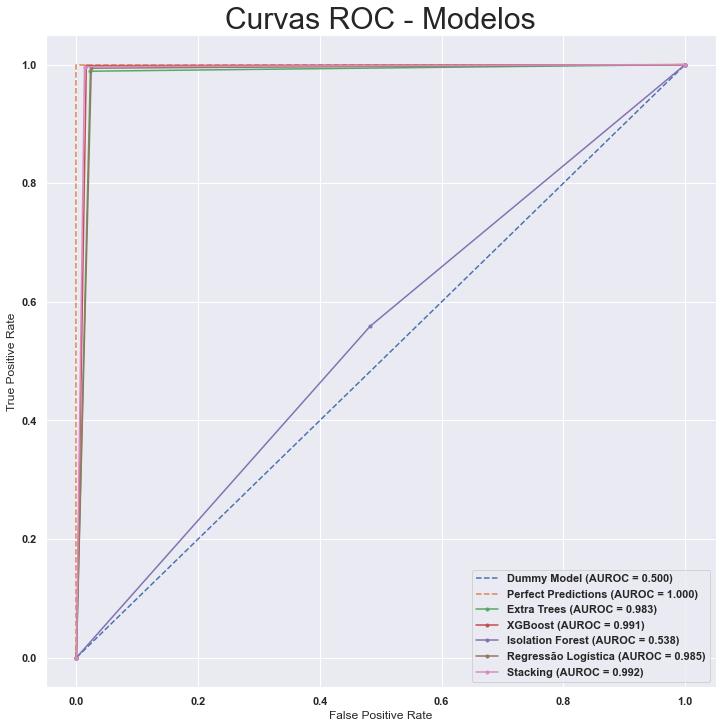

In [48]:
# Plotar

sns.set()
fig, ax = plt.subplots(figsize=(12, 12))

plt.plot(d_fpr, d_tpr, linestyle = '--', label = 'Dummy Model (AUROC = %0.3f)' % d_auc)
plt.plot(p_fpr, p_tpr, linestyle = '--', label = 'Perfect Predictions (AUROC = %0.3f)' % p_auc)
plt.plot(xtc_fpr, xtc_tpr, marker = '.', label = 'Extra Trees (AUROC = %0.3f)' % xtc_auc)
plt.plot(xgb_fpr, xgb_tpr, marker = '.', label = 'XGBoost (AUROC = %0.3f)' % xgb_auc)
plt.plot(ifc_fpr, ifc_tpr, marker = '.', label = 'Isolation Forest (AUROC = %0.3f)' % ifc_auc)
plt.plot(reglof_fpr, reglof_tpr, marker = '.', label = 'Regressão Logística (AUROC = %0.3f)' % reglog_auc)
plt.plot(stack_fpr, stack_tpr, marker = '.', label = 'Stacking (AUROC = %0.3f)' % stack_auc)

# Título
plt.title('Curvas ROC - Modelos', fontsize = 30)

# Rótulo dos eixos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Legenda
plt.legend()

plt.show()

<a id="title-six"></a>
<h1 style='background:#3E4491; border:2; border-radius: 10px; color:white;padding:20px'><center>Pickle e Simulação de Deploy</center></h1>

In [49]:
# Criando dataframe de deploy (cópia do dataset completo, com as transformações idênticas às de treino)

df_all = fraud_df.copy()
df_all = df_all.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'],
                     axis = 1
                     )

df_all = df_all.drop(df_clean.index, axis = 0)

df_all[numericals] = StandardScaler().fit_transform(df_all[numericals])
df_all['type'] = df_all['type'].factorize()[0]

X_all = df_all.drop('isFraud', axis = 1)
y_all = df_all['isFraud']

Aproveitando que utilizamos apenas parte dos dados nos treinamentos (graças ao undersampling 99.867% dos dados ficaram de fora), podemos utilizar os dados que não foram vistos pelos modelos e simular o *deploy* do melhor modelo em dados 'novos', assim testando a capacidade de generalização do preditor.

Portanto, primeiro vamos criar uma linearização exportável do modelo. Assim, numa situação comercial, teríamos um arquivo pronto para utilizar em servidor e/ou serviço de computação na nuvem.

* A título de exemplo e para análise comparativa, primeiro vamos fazer o deploy somente com o melhor modelo de Regressão Logística (**sozinha, SEM** o XGBoost do Stacking):

In [50]:
# Serializando o melhor modelo de Regressão Logística	

import pickle

pickle.dump(bayessearch_logreg.best_estimator_, open('modelo_logreg.pkl', 'wb'))

A seguinte célula representa tudo o que o servidor teria que realizar com dados novos para realizar as predições em campo.

In [51]:
# Carregando modelo e fazendo predições

pickle_model_logreg = pickle.load(open('modelo_logreg.pkl', 'rb'))

y_pred_deploy_logreg = pickle_model_logreg.predict(X_all)

Acurácia:  0.6556
              precision    recall  f1-score   support

           0       1.00      0.66      0.79   6349912
           1       0.00      0.00      0.00      4306

    accuracy                           0.66   6354218
   macro avg       0.50      0.33      0.40   6354218
weighted avg       1.00      0.66      0.79   6354218



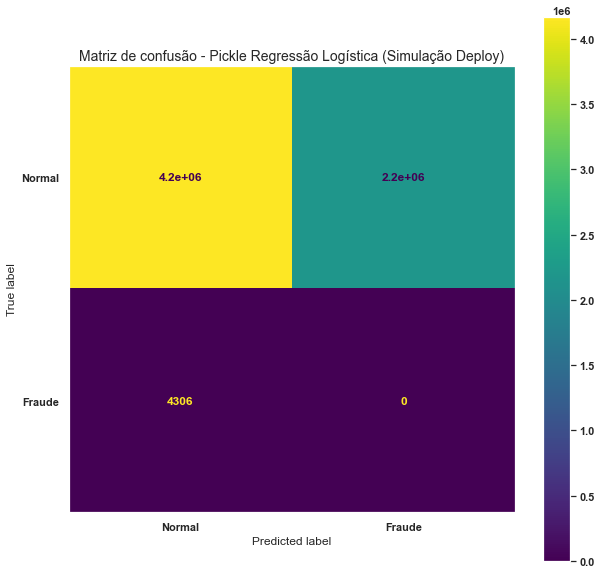

* Porcentagens da matriz de confusão:

[[65.556 34.376]
 [ 0.068  0.   ]]


In [52]:
# Imprimindo resultados: Acurácia, report de métricas e matriz confusão

print('Acurácia: ', accuracy_score(y_all, y_pred_deploy_logreg).round(4))

print(classification_report(y_all, y_pred_deploy_logreg))

cmp2 = ConfusionMatrixDisplay(confusion_matrix(y_all, y_pred_deploy_logreg), display_labels = ['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize = (10,10))
plt.grid(False)
cmp2.plot(ax = ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Pickle Regressão Logística (Simulação Deploy)', fontsize = 14)
plt.show()

print('* Porcentagens da matriz de confusão:\n')
logreg_deploy_cm = (100 * confusion_matrix(y_all, y_pred_deploy_logreg, normalize = 'all'))
for n, i in enumerate(logreg_deploy_cm):
    logreg_deploy_cm[n] = i.astype('float').round(3)
    
print(logreg_deploy_cm)

* ### Deploy com Stacking Classifier

In [53]:
# Serializando melhor modelo de Stacking (modelo final)

pickle.dump(stack, open('modelo_final.pkl', 'wb'))

A seguinte célula representa tudo o que o servidor teria que realizar com dados novos para realizar as predições em campo.

In [54]:
# Carregando modelo e fazendo predições

pickle_model = pickle.load(open('modelo_final.pkl', 'rb'))

y_pred_deploy = pickle_model.predict(X_all)

Acurácia:  0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6349912
           1       0.09      0.10      0.10      4306

    accuracy                           1.00   6354218
   macro avg       0.55      0.55      0.55   6354218
weighted avg       1.00      1.00      1.00   6354218



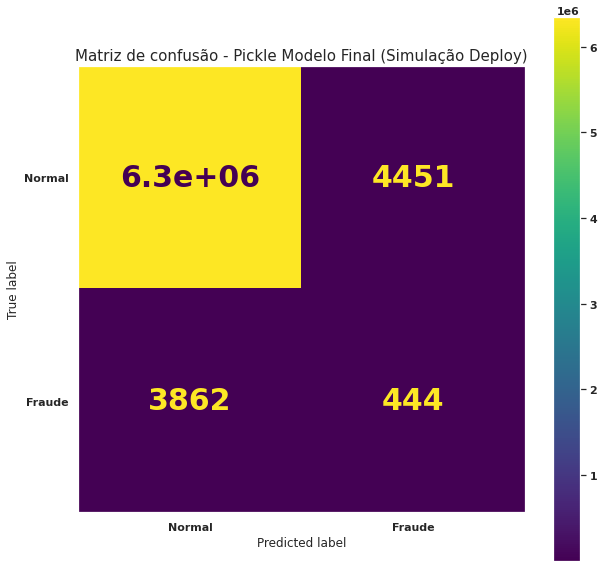

* Porcentagens da matriz de confusão:

[['99.862' '0.07']
 ['0.061' '0.007']]


In [55]:
# Imprimindo resultados: Acurácia, report de métricas e matriz confusão

print('Acurácia: ', accuracy_score(y_all, y_pred_deploy).round(4))

print(classification_report(y_all, y_pred_deploy))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_all, y_pred_deploy), display_labels = ['Normal', 'Fraude'])
fig, ax = plt.subplots(figsize = (10,10))
plt.grid(False)
cmp1.plot(ax = ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Pickle Modelo Final (Simulação Deploy)', fontsize = 15)
plt.show()

print('* Porcentagens da matriz de confusão:\n')
final_cm = (100 * confusion_matrix(y_all, y_pred_deploy, normalize = 'all')).astype('str')
for n, i in enumerate(final_cm):
    final_cm[n] = i.astype('float').round(3)
    
print(final_cm)

In [56]:
df_all['isFraud'].value_counts()

0    6349912
1       4306
Name: isFraud, dtype: int64

In [57]:
df_all['isFraud'].value_counts(normalize = True) * 100

0    99.932234
1     0.067766
Name: isFraud, dtype: float64

## Fim